In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use(['fivethirtyeight', 'figsize'])
_SAVEDIR_ = 'Tex/figures/'


def prog_bar(cur_val,max_val,msg = ""):
    import sys
    sys.stdout.write('\r')
    eq = int(np.ceil(np.true_divide(cur_val*100,max_val*5)))
    sys.stdout.write("[{:20s}] {}/{} {:}  ".format('='*eq, cur_val+1,max_val,msg))
    sys.stdout.flush()


In [61]:
# Define parameters
G = -5
visc = 1/6
dt = 1
dx = 1
rho_psi = 1
rho_in = .69
omega = 1/(3.*visc*(dt*dt)/(dx*dx) + 0.5*dt) # this is just one....
lx = 20
ly = 20
Nsteps = 1000
cs=1./np.sqrt(3)


w = [4./9,1./9,1./9,1./9,1./9,1./36,1./36,1./36,1./36] 
ex=[0,1,0,-1,0 ,1,-1,-1, 1]
ey=[0,0,1,0 ,-1,1, 1,-1,-1]


In [62]:
def init(rho_in):
    f = np.zeros([Nsteps, 9,lx,ly])
    
    rho = np.ones([lx,ly])*rho_in
    rho *= 1+.01*(np.random.rand(lx,ly)-.5)*2
    
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])
    for kk in range(0,9):  
        f[0,kk,:,:] = w[kk]*rho
    return f, rho, u ,v
        
    # Init rho with perturbation
def calc_macro(f,rho,u,v):
    # f should be at a given time step
    u[:,:] = 0
    v[:,:] = 0
    
    rho = np.sum(f,axis=0)
    for k in range(9):
        u += f[k]*ex[k]
#         print(ey[k])
        v += f[k]*ey[k]
    u=u/rho
    v=v/rho
    return rho, u ,v
def force(rho, u, v):
    # omega, and rho_psi are global variables
    psi = rho_psi*(1-np.exp(-rho/rho_psi))
    # a negative roll velocity implied i+1

    f_x = psi*(np.roll(psi,(0,-1),(0,1))-np.roll(psi,(0,1),(0,1)))
    f_y = psi*(np.roll(psi,(0,-1),(0,1))-np.roll(psi,(0,1),(0,1)))

    f2_x = psi*(np.roll(psi,(-1,1),(0,1))+np.roll(psi,(-1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(1,-1),(0,1)))


    f2_y = psi*(np.roll(psi,(-1,-1),(0,1))+np.roll(psi,(1,-1),(0,1))
                -np.roll(psi,(1,1),(0,1))-np.roll(psi,(-1,1),(0,1)))

    force_x = -G*(f_x*1/9+f2_x*1/36)
    force_y = -G*(f_y*1/9+f2_y*1/36)


    # shift equlibrium
    u += force_x/(omega*rho)
    v += force_y/(omega*rho)
    return u, v

def equilibrium(u, v, rho, f, ts):
    # also implements falcucci's collis method
    # maybe needs to return an object, but I think this should modify the original array
    for k in range(0,9):
        cu = (1./cs**2)*(ex[k]*u+ey[k]*v)
        feq = rho*w[k]*(1.+cu+cu**2-(u**2+v**2)/(2*cs**2))
        f[ts, k, :,:] = f[ts-1,k,:,:] +(1./omega)*(feq-f[ts-1,k,:,:])

def run():
# initialization
    f, rho, u, v = init(rho_in)
    
    # main loop
    for ts in range(1,Nsteps):
        # prog bar
        prog_bar(ts,Nsteps)
        
        # calc macro quanitites
        rho, u, v = calc_macro(f[ts-1],rho,u,v)

        # force + collision
        u, v = force(rho, u, v)
        equilibrium(u, v, rho, f, ts)


        # prepare the next time step
        fout = f[ts]

        # streaming
        for kk in range(0,9): 
            f[ts,kk,:,:] = np.roll(fout[kk,:,:],(ex[kk],ey[kk]),(0,1))
    return f
f_out = run()

[====================] 1000/1000   

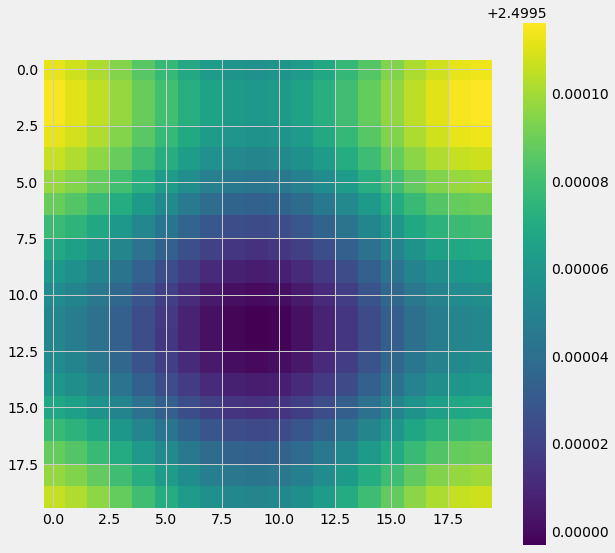

In [71]:
def calc_macro_f(f):
    #Assumes f at a given time step
    #  this fxn shouldn't be used in the loops as it takes times to create new numpy arrays
    # useful after running for getting macro quantities w/o having the rho,u, and v arrays handy
    u = np.zeros([lx,ly])
    v = np.zeros([lx,ly])
    
    rho = np.sum(f,axis=0)
    for k in range(9):
        u += f[k]*ex[k]
#         print(ey[k])
        v += f[k]*ey[k]
    u=u/rho
    v=v/rho
    return rho, u ,v
plt.imshow(calc_macro_f(f_out[500])[0])
plt.colorbar()
plt.show()

In [68]:
calc_macro_f(f_out[-1])[0]

array([[ 2.49955664,  2.49955664,  2.49955664,  2.49955664,  2.49955664,
         2.49955664,  2.49955664,  2.49955664,  2.49955664,  2.49955664,
         2.49955663,  2.49955663,  2.49955663,  2.49955663,  2.49955664,
         2.49955664,  2.49955664,  2.49955664,  2.49955664,  2.49955664],
       [ 2.49955664,  2.49955664,  2.49955664,  2.49955664,  2.49955664,
         2.49955664,  2.49955664,  2.49955664,  2.49955664,  2.49955664,
         2.49955663,  2.49955663,  2.49955663,  2.49955663,  2.49955663,
         2.49955664,  2.49955664,  2.49955664,  2.49955664,  2.49955664],
       [ 2.49955664,  2.49955664,  2.49955664,  2.49955664,  2.49955664,
         2.49955664,  2.49955664,  2.49955664,  2.49955664,  2.49955664,
         2.49955663,  2.49955663,  2.49955663,  2.49955663,  2.49955663,
         2.49955664,  2.49955664,  2.49955664,  2.49955664,  2.49955664],
       [ 2.49955664,  2.49955664,  2.49955664,  2.49955664,  2.49955664,
         2.49955664,  2.49955664,  2.49955664,  

In [ ]:
psi = np.arange(1,5)
print(psi)
print(psi*(np.roll(psi,-1,0)-np.roll(psi,1,0)))
for i in range(4):
    print(psi[i]*(psi[(i+1)%4]-psi[i-1]))

In [29]:
psi =np.zeros([5,5])
psi[:,:] = np.arange(1,6)
psi[3,4] = 4
print(psi*(np.roll(psi,(-1,0),(0,1))-np.roll(psi,(1,0),(0,1))))
for i in range(5):
    print(psi[i,:]*(psi[(i+1)%4,:]-psi[i-1,:]))

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -5.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  5.]]
[ 0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.]
[ 0.  0.  0.  0. -5.]
[ 0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  5.]


In [33]:
# a negative roll velocity implied i+1

f_x = psi*(np.roll(psi,(0,-1),(0,1))-np.roll(psi,(0,1),(0,1)))
f_y = psi*(np.roll(psi,(0,-1),(0,1))-np.roll(psi,(0,1),(0,1)))

f2_x = psi*(np.roll(psi,(-1,1),(0,1))+np.roll(psi,(-1,-1),(0,1))
            -np.roll(psi,(1,1),(0,1))-np.roll(psi,(1,-1),(0,1)))


f2_y = psi*(np.roll(psi,(-1,-1),(0,1))+np.roll(psi,(1,-1),(0,1))
            -np.roll(psi,(1,1),(0,1))-np.roll(psi,(-1,1),(0,1)))

force_x = -G*(f_x*1/9+f2_x*1/36)
force_y = -G*(f_y*1/9+f2_y*1/36)


# shift equlibrium
u += force_x/(omega*rho)
v += force_y/(omega*rho)

NameError: name 'u' is not defined